In [1]:
import csv

import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

RANDOM_SEED = 42

In [20]:
dataset = 'data_glove/Data_joren.csv'
dataset_extra = 'data_glove/data_martijn_zus.csv'
dataset_test = 'data_glove/glove_test_data.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier_glove.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier_glove.tflite'

In [21]:
NUM_CLASSES = 24

In [22]:
arr = pd.read_csv(dataset, header=None, delimiter=";")
# check the shape
input_shape = arr.shape
print(arr.iloc[0])
print(arr.iloc[1])
print(f"The input shape of your array is: {input_shape}")

0    0,0,0,0,3.519914,0.050033,3.621713,6.846703,-2...
Name: 0, dtype: object
0    0,0,0,0,3.519914,0.050033,3.621713,6.847597,-2...
Name: 1, dtype: object
The input shape of your array is: (9600, 1)


In [24]:
#X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, 365)))
#X_dataset_original = X_dataset = np.loadtxt(dataset_original, delimiter=',', dtype='float32', usecols=list(range(300, 325)) + list(range(4, 151)))
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(300, 325)) + list(range(4, 151)))
X_dataset_extra = np.loadtxt(dataset_extra, delimiter=',', dtype='float32', usecols=list(range(300, 325)) + list(range(4, 151)), skiprows=1)
X_dataset = np.concatenate((X_dataset, X_dataset_extra), axis=0)
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))
y_dataset_extra = np.loadtxt(dataset_extra, delimiter=',', dtype='int32', usecols=(0), skiprows=1)
y_dataset = np.concatenate((y_dataset, y_dataset_extra), axis=0)

X_train, X_validation, y_train, y_validation = train_test_split(X_dataset, y_dataset, train_size=0.70, random_state=RANDOM_SEED)
#X_test, X_validation, y_test, y_validation = train_test_split(X, y, train_size=0.70, random_state=RANDOM_SEED)
X_test = np.loadtxt(dataset_test, delimiter=',', dtype='float32', usecols=list(range(300, 325)) + list(range(4, 151)))
y_test = np.loadtxt(dataset_test, delimiter=',', dtype='int32', usecols=(0))

In [25]:
print(X_dataset.shape)

(12000, 172)


In [26]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((172, 1), input_shape=(172,)),
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

C:\thesis\venv\lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [27]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((172, 1), input_shape=(172,)),
    tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [28]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_4 (Reshape)             │ (None, 172, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 172, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 86, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 86, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 43, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 43, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2688)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2688)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │       688,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 755,416 (2.88 MB)

 Trainable params: 755,416 (2.88 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [30]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [31]:
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_validation, y_validation),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1242 - loss: 6.4730
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier_glove.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.1269 - loss: 6.4083 - val_accuracy: 0.6233 - val_loss: 1.6205
Epoch 2/1000
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4845 - loss: 2.2045
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier_glove.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4878 - loss: 2.1866 - val_accuracy: 0.8367 - val_loss: 0.7148
Epoch 3/1000
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7129 - loss: 1.0426
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier_glove.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7137 - loss: 1.0394 - val_accuracy: 0.9306 - val_loss: 0.2786
Epoch 4/1000
63/66 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8064 - loss: 0.6375
Epoch 4: saving model to model/keypoint_classifier/keyp

In [34]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8234 - loss: 1.8893


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


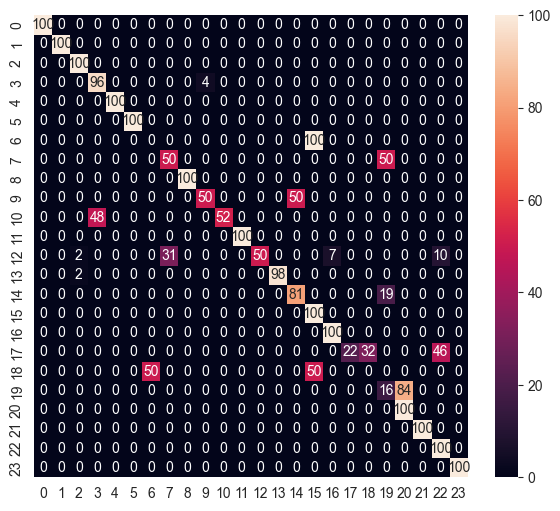

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100
           2       0.96      1.00      0.98       100
           3       0.67      0.96      0.79       100
           4       1.00      1.00      1.00       100
           5       1.00      1.00      1.00       100
           6       0.00      0.00      0.00       100
           7       0.62      0.50      0.55       100
           8       1.00      1.00      1.00       100
           9       0.93      0.50      0.65       100
          10       1.00      0.52      0.68       100
          11       1.00      1.00      1.00       100
          12       1.00      0.50      0.67       100
          13       1.00      0.98      0.99       100
          14       0.62      0.81      0.70       100
          15       0.40      1.00      0.57       100
          16       0.93      1.00      0.97       100
     

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()

    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

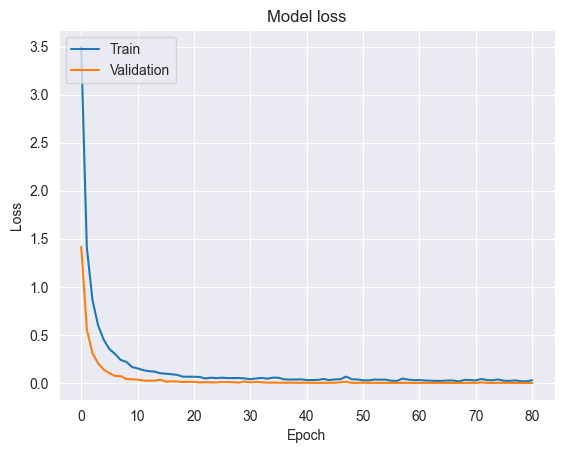

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

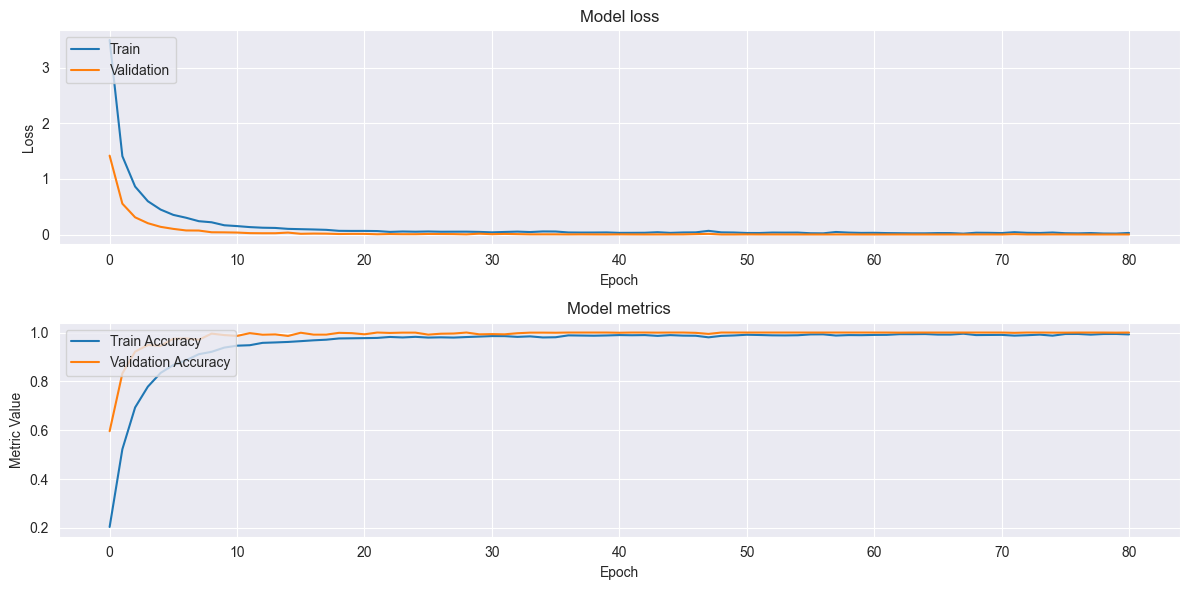

In [43]:
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy and F1 score values
plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model metrics')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'F1 Score'], loc='upper left')

plt.tight_layout()
plt.show()